
<div class="alert alert-info">

**This is a fixed-text formatted version of a Jupyter notebook**

- Try online [![Binder](https://static.mybinder.org/badge.svg)](https://mybinder.org/v2/gh/gammapy/gammapy-webpage/master?urlpath=lab/tree/mcmc_sampling.ipynb)
- You can contribute with your own notebooks in this
[GitHub repository](https://github.com/gammapy/gammapy/tree/master/docs/tutorials).
- **Source files:**
[mcmc_sampling.ipynb](../_static/notebooks/mcmc_sampling.ipynb) |
[mcmc_sampling.py](../_static/notebooks/mcmc_sampling.py)
</div>


# Fitting and error estimation with MCMC

## Introduction

The goal of Markov Chain Monte Carlo (MCMC) algorithms is to approximate the posterior distribution of your model parameters by random sampling in a probabilistic space. For most readers this sentence was probably not very helpful so here we'll start straight with and example but you should read the more detailed mathematical approaches of the method [here](https://www.pas.rochester.edu/~sybenzvi/courses/phy403/2015s/p403_17_mcmc.pdf) and [here](https://github.com/jakevdp/BayesianAstronomy/blob/master/03-Bayesian-Modeling-With-MCMC.ipynb).

### How does it work ?

The idea is that we use a number of walkers that will sample the posterior distribution (i.e. sample the Likelihood profile).

The goal is to produce a "chain", i.e. a list of $\theta$ values, where each $\theta$ is a vector of parameters for your model.<br>
If you start far away from the truth value, the chain will take some time to converge until it reaches a stationary state. Once it has reached this stage, each successive elements of the chain are samples of the target posterior distribution.<br>
This means that, once we have obtained the chain of samples, we have everything we need. We can compute the  distribution of each parameter by simply approximating it with the histogram of the samples projected into the parameter space. This will provide the errors and correlations between parameters.


Now let's try to put a picture on the ideas described above. With this notebook, we have simulated and carried out a MCMC analysis for a source with the following parameters:<br>
$Index=2.0$, $Norm=5\times10^{-12}$ cm$^{-2}$ s$^{-1}$ TeV$^{-1}$, $Lambda =(1/Ecut) = 0.02$ TeV$^{-1}$ (50 TeV) for 20 hours.

The results that you can get from a MCMC analysis will look like this :

<img src="images/gammapy_mcmc.png" width="800">

On the first two top panels, we show the pseudo-random walk of one walker from an offset starting value to see it evolve to a better solution.
In the bottom right panel, we show the trace of each 16 walkers for 500 runs (the chain described previsouly). For the first 100 runs, the parameter evolve towards a solution (can be viewed as a fitting step). Then they explore the local minimum for 400 runs which will be used to estimate the parameters correlations and errors.
The choice of the Nburn value (when walkers have reached a stationary stage) can be done by eye but you can also look at the autocorrelation time.

### Why should I use it ?

When it comes to evaluate errors and investigate parameter correlation, one typically estimate the Likelihood in a gridded search (2D Likelihood profiles). Each point of the grid implies a new model fitting. If we use 10 steps for each parameters, we will need to carry out 100 fitting procedures. 

Now let's say that I have a model with $N$ parameters, we need to carry out that gridded analysis $N*(N-1)$ times. 
So for 5 free parameters you need 20 gridded search, resulting in 2000 individual fit. 
Clearly this strategy doesn't scale well to high-dimensional models.

Just for fun: if each fit procedure takes 10s, we're talking about 5h of computing time to estimate the correlation plots. 

There are many MCMC packages in the python ecosystem but here we will focus on [emcee](https://emcee.readthedocs.io), a lightweight Python package. A description is provided here : [Foreman-Mackey, Hogg, Lang & Goodman (2012)](https://arxiv.org/abs/1202.3665).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from gammapy.irf import load_cta_irfs
from gammapy.maps import WcsGeom, MapAxis
from gammapy.modeling.models import (
    ExpCutoffPowerLawSpectralModel,
    GaussianSpatialModel,
    SkyModel,
    Models,
    FoVBackgroundModel,
)
from gammapy.datasets import MapDataset
from gammapy.makers import MapDatasetMaker
from gammapy.data import Observation
from gammapy.modeling.sampling import (
    run_mcmc,
    par_to_model,
    plot_corner,
    plot_trace,
)

In [3]:
import logging

logging.basicConfig(level=logging.INFO)

## Simulate an observation

Here we will start by simulating an observation using the `simulate_dataset` method.

In [4]:
irfs = load_cta_irfs(
    "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
)

observation = Observation.create(
    pointing=SkyCoord(0 * u.deg, 0 * u.deg, frame="galactic"),
    livetime=20 * u.h,
    irfs=irfs,
)

In [5]:
# Define map geometry
axis = MapAxis.from_edges(
    np.logspace(-1, 2, 15), unit="TeV", name="energy", interp="log"
)

geom = WcsGeom.create(
    skydir=(0, 0), binsz=0.05, width=(2, 2), frame="galactic", axes=[axis]
)

empty_dataset = MapDataset.create(geom=geom, name="dataset-mcmc")
maker = MapDatasetMaker(selection=["background", "edisp", "psf", "exposure"])
dataset = maker.run(empty_dataset, observation)

In [6]:
# Define sky model to simulate the data
spatial_model = GaussianSpatialModel(
    lon_0="0 deg", lat_0="0 deg", sigma="0.2 deg", frame="galactic"
)

spectral_model = ExpCutoffPowerLawSpectralModel(
    index=2,
    amplitude="3e-12 cm-2 s-1 TeV-1",
    reference="1 TeV",
    lambda_="0.05 TeV-1",
)

sky_model_simu = SkyModel(
    spatial_model=spatial_model, spectral_model=spectral_model, name="source"
)

bkg_model = FoVBackgroundModel(dataset_name="dataset-mcmc")
models = Models([sky_model_simu, bkg_model])
print(models)

Models

Component 0: SkyModel

  Name                      : source
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    index                   :   2.000              
    amplitude               :   3.00e-12  1 / (cm2 s TeV)
    reference    (frozen)   :   1.000  TeV         
    lambda_                 :   0.050  1 / TeV     
    alpha        (frozen)   :   1.000              
    lon_0                   :   0.000  deg         
    lat_0                   :   0.000  deg         
    sigma                   :   0.200  deg         
    e            (frozen)   :   0.000              
    phi          (frozen)   :   0.000  deg         

Component 1: FoVBackgroundModel

  Name                      : dataset-mcmc-bkg
  Datasets names            : ['dataset-mcmc']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm        

In [7]:
dataset.models = models
dataset.fake()

(<Figure size 432x288 with 2 Axes>,
 <WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>,
 <matplotlib.colorbar.Colorbar at 0x7f81b0801438>)

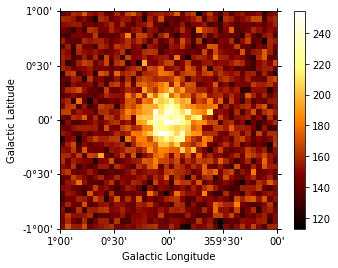

In [8]:
dataset.counts.sum_over_axes().plot(add_cbar=True);

In [9]:
# If you want to fit the data for comparison with MCMC later

# fit = Fit(dataset)
# result = fit.run(optimize_opts={"print_level": 1})

## Estimate parameter correlations with MCMC

Now let's analyse the simulated data.
Here we just fit it again with the same model we had before as a starting point.
The data that would be needed are the following: 
- counts cube, psf cube, exposure cube and background model

Luckily all those maps are already in the Dataset object.

We will need to define a Likelihood function and define priors on parameters.<br>
Here we will assume a uniform prior reading the min, max parameters from the sky model.

### Define priors

This steps is a bit manual for the moment until we find a better API to define priors.<br>
Note the you **need** to define priors for each parameter otherwise your walkers can explore uncharted territories (e.g. negative norms).

In [10]:
print(dataset)

MapDataset
----------

  Name                            : dataset-mcmc 

  Total counts                    : 248142 
  Total background counts         : 238923.09
  Total excess counts             : 9218.91

  Predicted counts                : 248096.17
  Predicted background counts     : 238923.09
  Predicted excess counts         : 9173.09

  Exposure min                    : 1.14e+10 m2 s
  Exposure max                    : 3.45e+11 m2 s

  Number of total bins            : 22400 
  Number of fit bins              : 22400 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -1296762.33

  Number of models                : 2 
  Number of parameters            : 13
  Number of free parameters       : 7

  Component 0: SkyModel
  
    Name                      : source
    Datasets names            : None
    Spectral model type       : ExpCutoffPowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model type       : 
    Par

In [11]:
# Define the free parameters and min, max values
parameters = dataset.models.parameters

parameters["sigma"].frozen = True
parameters["lon_0"].frozen = True
parameters["lat_0"].frozen = True
parameters["amplitude"].frozen = False
parameters["index"].frozen = False
parameters["lambda_"].frozen = False


parameters["norm"].frozen = True
parameters["tilt"].frozen = True

parameters["norm"].min = 0.5
parameters["norm"].max = 2

parameters["index"].min = 1
parameters["index"].max = 5
parameters["lambda_"].min = 1e-3
parameters["lambda_"].max = 1

parameters["amplitude"].min = 0.01 * parameters["amplitude"].value
parameters["amplitude"].max = 100 * parameters["amplitude"].value

parameters["sigma"].min = 0.05
parameters["sigma"].max = 1

# Setting amplitude init values a bit offset to see evolution
# Here starting close to the real value
parameters["index"].value = 2.0
parameters["amplitude"].value = 3.2e-12
parameters["lambda_"].value = 0.05

print(dataset.models)
print("stat =", dataset.stat_sum())

DatasetModels

Component 0: SkyModel

  Name                      : source
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    index                   :   2.000              
    amplitude               :   3.20e-12  1 / (cm2 s TeV)
    reference    (frozen)   :   1.000  TeV         
    lambda_                 :   0.050  1 / TeV     
    alpha        (frozen)   :   1.000              
    lon_0        (frozen)   :   0.000  deg         
    lat_0        (frozen)   :   0.000  deg         
    sigma        (frozen)   :   0.200  deg         
    e            (frozen)   :   0.000              
    phi          (frozen)   :   0.000  deg         

Component 1: FoVBackgroundModel

  Name                      : dataset-mcmc-bkg
  Datasets names            : ['dataset-mcmc']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm 

In [12]:
%%time
# Now let's define a function to init parameters and run the MCMC with emcee
# Depending on your number of walkers, Nrun and dimensionality, this can take a while (> minutes)
sampler = run_mcmc(dataset, nwalkers=6, nrun=150)  # to speedup the notebook
# sampler=run_mcmc(dataset,nwalkers=12,nrun=1000) # more accurate contours

INFO:gammapy.modeling.sampling:Free parameters: ['index', 'amplitude', 'lambda_']
INFO:gammapy.modeling.sampling:Starting MCMC sampling: nwalkers=6, nrun=150
INFO:gammapy.modeling.sampling:   0%
INFO:gammapy.modeling.sampling:  50%
INFO:gammapy.modeling.sampling:100% => sampling completed


CPU times: user 6.89 s, sys: 0 ns, total: 6.89 s
Wall time: 6.89 s


## Plot the results

The MCMC will return a sampler object containing the trace of all walkers.<br>
The most important part is the chain attribute which is an array of shape:<br>
_(nwalkers, nrun, nfreeparam)_

The chain is then used to plot the trace of the walkers and estimate the burnin period (the time for the walkers to reach a stationary stage).

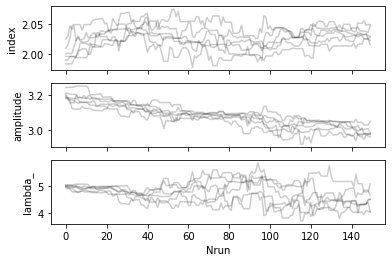

In [13]:
plot_trace(sampler, dataset)

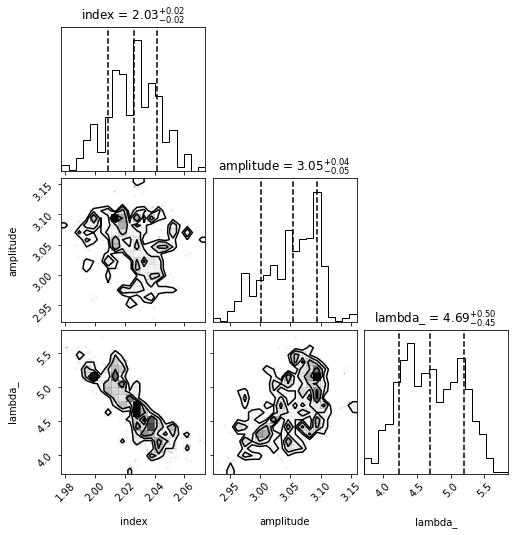

In [14]:
plot_corner(sampler, dataset, nburn=50)

## Plot the model dispersion

Using the samples from the chain after the burn period, we can plot the different models compared to the truth model. To do this we need to the spectral models for each parameter state in the sample.

/home/runner/work/gammapy-docs/gammapy-docs/gammapy/gammapy/modeling/models/spectral.py:405: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("log", nonposx="clip")
/home/runner/work/gammapy-docs/gammapy-docs/gammapy/gammapy/modeling/models/spectral.py:406: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale("log", nonposy="clip")
/home/runner/work/gammapy-docs/gammapy-docs/gammapy/gammapy/modeling/models/spectral.py:405: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("log", nonposx="clip")
/home/runner/work/gammapy-docs/gammapy-d

<AxesSubplot:xlabel='Energy [TeV]', ylabel='E2 * Flux [TeV / (cm2 s)]'>

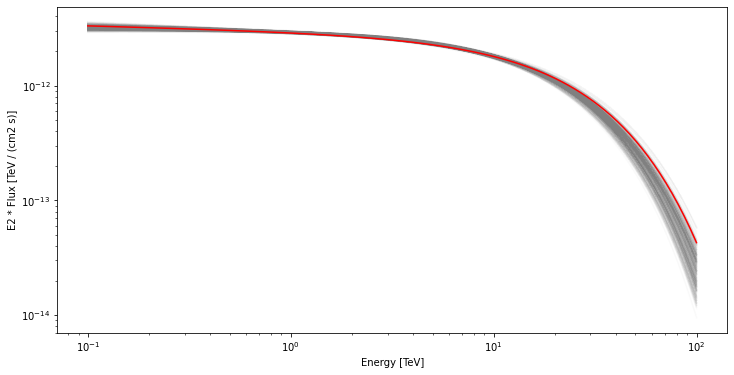

In [15]:
emin, emax = [0.1, 100] * u.TeV
nburn = 50

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

for nwalk in range(0, 6):
    for n in range(nburn, nburn + 100):
        pars = sampler.chain[nwalk, n, :]

        # set model parameters
        par_to_model(dataset, pars)
        spectral_model = dataset.models["source"].spectral_model

        spectral_model.plot(
            energy_range=(emin, emax),
            ax=ax,
            energy_power=2,
            alpha=0.02,
            color="grey",
        )


sky_model_simu.spectral_model.plot(
    energy_range=(emin, emax), energy_power=2, ax=ax, color="red"
);

## Fun Zone

Now that you have the sampler chain, you have in your hands the entire history of each walkers in the N-Dimensional parameter space. <br>
You can for example trace the steps of each walker in any parameter space.

Text(0, 0.5, 'Amplitude')

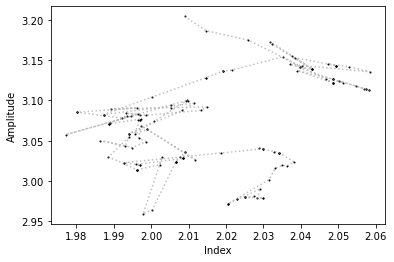

In [16]:
# Here we plot the trace of one walker in a given parameter space
parx, pary = 0, 1

plt.plot(sampler.chain[0, :, parx], sampler.chain[0, :, pary], "ko", ms=1)
plt.plot(
    sampler.chain[0, :, parx],
    sampler.chain[0, :, pary],
    ls=":",
    color="grey",
    alpha=0.5,
)

plt.xlabel("Index")
plt.ylabel("Amplitude");

## PeVatrons in CTA ?

Now it's your turn to play with this MCMC notebook. For example to test the CTA performance to measure a cutoff at very high energies (100 TeV ?).

After defining your Skymodel it can be as simple as this :

In [17]:
# dataset = simulate_dataset(model, geom, pointing, irfs)
# sampler = run_mcmc(dataset)
# plot_trace(sampler, dataset)
# plot_corner(sampler, dataset, nburn=200)